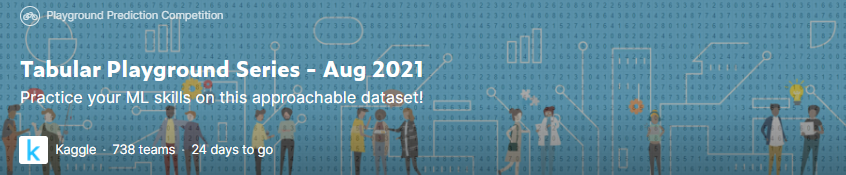

### <span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Simple Optuna+LightGBM</span>

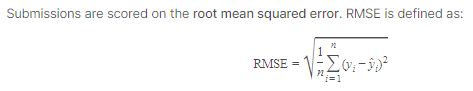

### Final submission deadline - August 31, 2021

In [ ]:
import sys
import os
import math
import time
import random
import shutil
from pathlib import Path

import scipy as sp
import numpy as np
import pandas as pd


In [ ]:
train = pd.read_csv('../input/tabular-playground-series-aug-2021/train.csv')
target = train.loss
train = train.drop(['id','loss'],axis=1)
train

## Thanks a lot. plese upvote it.<br>
https://www.kaggle.com/oxzplvifi/tabular-denoising-residual-network<br>
https://www.kaggle.com/alexryzhkov/aug21-lightautoml-starter

In [ ]:
train_add = pd.read_csv('../input/tabular-denoising-residual-network/yoof.csv')
train_add = train_add.rename(columns={'loss':'pred'})
train_add = train_add.drop(['ID'],axis=1)
train = pd.concat([train,train_add],axis=1)
train

In [ ]:
test = pd.read_csv('../input/tabular-playground-series-aug-2021/test.csv')
test = test.drop(['id'],axis=1)
test

In [ ]:
test_add = pd.read_csv('../input/tabular-denoising-residual-network/submission.csv')
test_add = test_add.rename(columns={'loss':'pred'})
test_add = test_add.drop(['ID'],axis=1)
test = pd.concat([test,test_add],axis=1)
test

In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Optuna</span>

In [ ]:

#!pip install optuna
import optuna 
import optuna.integration.lightgbm as lgbo

params = {'objective': 'poisson',  'metric': 'rmse' } #'objective': 'mean_squared_error',
from sklearn.metrics import mean_absolute_error
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.3, random_state=42)
lgb_train = lgb.Dataset(x_train, y_train)
lgb_valid = lgb.Dataset(x_test, y_test)
model = lgbo.train(params, lgb_train, valid_sets=[lgb_valid], verbose_eval=False, num_boost_round=100, early_stopping_rounds=5) 
model.params


In [ ]:
best_lgb_params =model.params
best_lgb_params["learning_rate"] = 0.006
best_lgb_params["early_stopping_round"] = 200
best_lgb_params["num_iterations"] = 80000

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Training</span>

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
spl=5
kf = KFold(n_splits=spl, random_state=77, shuffle=True)
models =[]
for fold, (trn_idx, val_idx) in enumerate(kf.split(train, target)):

    print("Fold :", fold+1)
    
    # create dataset
    x_train, y_train = train.loc[trn_idx], target.loc[trn_idx]
    x_test,  y_test = train.loc[val_idx], target.loc[val_idx]
 
    #x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=42)
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_valid = lgb.Dataset(x_test, y_test)
 
    model = lgb.train(best_lgb_params,lgb_train, valid_sets=[lgb_valid], verbose_eval=100)
    lpred = model.predict(x_test)

    models.append(model)
    
    print('#### fold #########',np.sqrt(mean_squared_error(y_test, lpred)),mean_squared_error(y_test, lpred))

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Evaluation</span>

In [ ]:
lpred=[]
for model in models:
   lpred.append(model.predict(x_test))
pred=lpred[0]
for i in range(1,spl):
   pred += lpred[i]
pred = pred /spl
print('#### fold #########',np.sqrt(mean_squared_error(y_test, pred)),mean_squared_error(y_test, pred))

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Inference</span>

In [ ]:
#lightGBM
lpred=[]
for model in models:
   lpred.append(model.predict(test))
pred=lpred[0]
for i in range(1,spl):
   pred += lpred[i]
pred = pred /spl
pred

In [ ]:
sub = pd.read_csv('../input/tabular-playground-series-aug-2021/sample_submission.csv')
sub.loss = pred
sub.to_csv('submit.csv',index=False)
sub

㊙🔰🗑⬛🟥🟨🟩